In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingCNNAutoencoderConfig:    
    root_dir: Path
    trained_od_model_path: Path    
    base_od_model_path: Path
    trained_tensor_model_path: Path    
    base_tensor_model_path: Path     
    training_od_data: Path    
    training_tensor_data: Path    
    params_od_size: list
    params_tensor_size: list
    params_epochs: int
    params_batch_size: int   
    learning_rate: float
    validation_ratio: float

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path
    patience: int

In [4]:
from timeseriesPredictor.utils import read_yaml, create_directories
from timeseriesPredictor.constants import *

In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath,
           patience = self.params.PATIENCE

        )

        return prepare_callbacks_config
    
    def get_autoencoder_training_config(self) -> TrainingCNNAutoencoderConfig:
        config= self.config.training_autoencoder        
        
        create_directories([config.root_dir])

        training_autoencoder_config = TrainingCNNAutoencoderConfig(
        root_dir= config.root_dir,
        trained_od_model_path= config.trained_od_model_path, 
        base_od_model_path = self.config.prepare_autoencoder_base_model.base_od_model_path,
        trained_tensor_model_path= config.trained_tensor_model_path, 
        base_tensor_model_path = self.config.prepare_autoencoder_base_model.base_tensor_model_path,
        training_od_data= self.config.data_transformation.local_train_od_dir,        
        training_tensor_data=self.config.data_transformation.local_train_tensor_dir,        
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE,      
        params_od_size= self.params.OD_SIZE,
        params_tensor_size=self.params.TENSOR_SIZE,
        learning_rate= self.params.LEARNING_RATE,
        validation_ratio= self.params.VALIDATION_RATIO
        )

        return training_autoencoder_config

In [6]:
from timeseriesPredictor.utils import model_loss
import keras
import pickle

2023-08-14 14:11:35.654328: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 14:11:35.706002: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 14:11:35.706744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 14:11:36.447556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
class TrainingCNNAutoencoder:
    def __init__(self, config: TrainingCNNAutoencoderConfig):
        self.config= config

    @staticmethod
    def get_base_model(path:Path):
        model = keras.models.load_model(path)
        return model  

    @staticmethod
    def load_pickle_file(path: Path):
        file= open(path, 'rb')
        obj = pickle.load(file)
        return obj
    
    @staticmethod
    def save_model(path:Path, model:keras.Model):
        model.save(path)

    def train(self, callback_list: list): 
        X_trains = [self.load_pickle_file(self.config.training_od_data) , self.load_pickle_file(self.config.training_tensor_data)]
        base_model_paths = [self.config.base_od_model_path, self.config.base_tensor_model_path] 
        trained_model_paths = [self.config.trained_od_model_path, self.config.trained_tensor_model_path]       
        
        for base_model_path, X_train, trained_model_path in zip(base_model_paths, X_trains, trained_model_paths):
            model = self.get_base_model(base_model_path) 
            history = model.fit(X_train, X_train,
                validation_split=self.config.validation_ratio,           
                epochs= self.config.params_epochs,
                batch_size = self.config.params_batch_size,            
                callbacks = callback_list
                )
        
            model_loss(history)
            self.save_model(path=trained_model_path, model= model)

In [8]:
import sys
from timeseriesPredictor.exception import CustomException
from timeseriesPredictor.components.prepare_callbacks import PrepareCallbacks 

Epoch 1/100
17/17 [==============================] - 4s 195ms/step - loss: 2.1192 - MSE: 2.1192 - val_loss: 0.0297 - val_MSE: 0.0297
Epoch 2/100


/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 4s 229ms/step - loss: 0.6763 - MSE: 0.6763 - val_loss: 0.0299 - val_MSE: 0.0299
Epoch 3/100
17/17 [==============================] - 4s 222ms/step - loss: 0.5079 - MSE: 0.5079 - val_loss: 0.0302 - val_MSE: 0.0302
Epoch 4/100
17/17 [==============================] - 3s 178ms/step - loss: 0.4280 - MSE: 0.4280 - val_loss: 0.0303 - val_MSE: 0.0303
Epoch 5/100
17/17 [==============================] - 3s 182ms/step - loss: 0.3725 - MSE: 0.3725 - val_loss: 0.0292 - val_MSE: 0.0292
Epoch 6/100
17/17 [==============================] - 3s 196ms/step - loss: 0.3287 - MSE: 0.3287 - val_loss: 0.0281 - val_MSE: 0.0281
Epoch 7/100
17/17 [==============================] - 4s 226ms/step - loss: 0.2918 - MSE: 0.2918 - val_loss: 0.0270 - val_MSE: 0.0270
Epoch 8/100
17/17 [==============================] - 4s 218ms/step - loss: 0.2603 - MSE: 0.2603 - val_loss: 0.0264 - val_MSE: 0.0264
Epoch 9/100
17/17 [==============================] - 4s 244ms/step - loss: 0.2328

/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction/src/timeseriesPredictor/utils.py:203: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


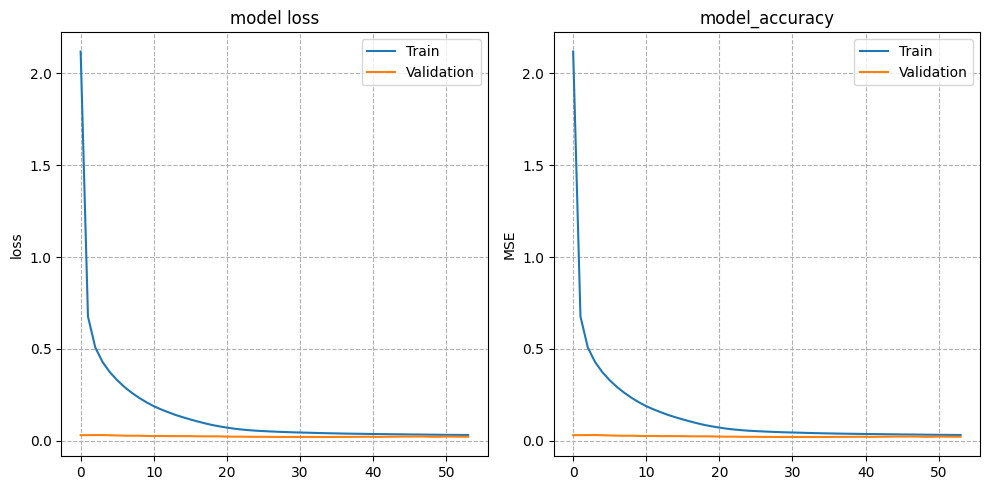

Epoch 1/100
17/17 [==============================] - 6s 327ms/step - loss: 1.5470 - MSE: 1.5470 - val_loss: 0.0204 - val_MSE: 0.0204
Epoch 2/100
17/17 [==============================] - 5s 319ms/step - loss: 0.6561 - MSE: 0.6561 - val_loss: 0.0196 - val_MSE: 0.0196
Epoch 3/100
17/17 [==============================] - 6s 326ms/step - loss: 0.5072 - MSE: 0.5072 - val_loss: 0.0201 - val_MSE: 0.0201
Epoch 4/100
17/17 [==============================] - 5s 314ms/step - loss: 0.4266 - MSE: 0.4266 - val_loss: 0.0208 - val_MSE: 0.0208
Epoch 5/100
17/17 [==============================] - 5s 315ms/step - loss: 0.3676 - MSE: 0.3676 - val_loss: 0.0215 - val_MSE: 0.0215
Epoch 6/100
17/17 [==============================] - 5s 315ms/step - loss: 0.3203 - MSE: 0.3203 - val_loss: 0.0218 - val_MSE: 0.0218
Epoch 7/100
17/17 [==============================] - 5s 318ms/step - loss: 0.2807 - MSE: 0.2807 - val_loss: 0.0220 - val_MSE: 0.0220
Epoch 8/100
17/17 [==============================] - 5s 316ms/step - 

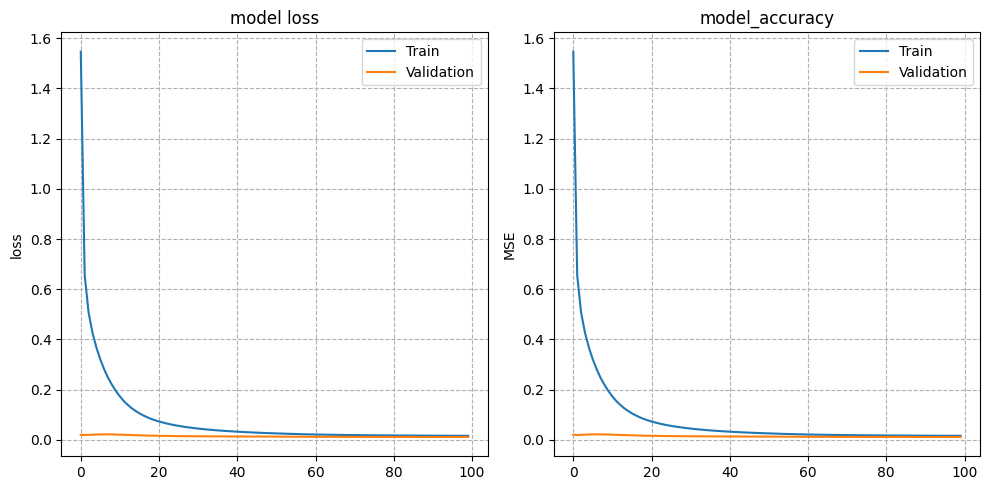

In [9]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_es_callbacks()

    training_config = config.get_autoencoder_training_config()
    training = TrainingCNNAutoencoder(config= training_config)   
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)